In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()
%matplotlib inline

np.random.seed(3)

In [3]:
all_GATGA=pd.read_csv('/home/jiayi/5moU/data/DL_fromTombo/all_GATGA.csv')
all_GATGA

,indx,kmer,mean_1,mean_2,mean_3,mean_4,mean_5,std_1,std_2,std_3,...,mdintense_2,mdintense_3,mdintense_4,mdintense_5,L-1,L-2,L-3,L-4,L-5,label
0,174,GATGA,0.910491,-0.488466,-0.154817,0.476361,0.603461,0.135782,0.049470,0.049517,...,-0.488062,-0.152912,0.446169,0.555092,6,83,11,29,11,1
1,173,GATGA,0.740966,-0.456914,-0.223984,0.660435,0.498778,0.318883,0.054712,0.066413,...,-0.454593,-0.230468,0.651231,0.475737,25,82,15,34,107,1
2,157,GATGA,0.925567,-0.434805,-0.194485,0.515178,0.496787,0.066500,0.123603,0.037831,...,-0.457246,-0.188278,0.552420,0.486212,17,378,6,6,27,1
3,174,GATGA,0.631904,-0.325172,-0.069864,0.501238,0.534491,0.344535,0.097926,0.073734,...,-0.329310,-0.051579,0.478094,0.484046,15,256,23,6,21,1
4,174,GATGA,0.563095,-0.476060,-0.225073,0.621785,0.353257,0.471024,0.060429,0.052804,...,-0.474344,-0.234170,0.652474,0.372270,35,259,22,12,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,172,GATGA,0.913120,-0.796517,-0.503154,0.552831,0.272477,0.375421,0.122900,0.119425,...,-0.795433,-0.483772,0.497727,0.279099,20,133,6,13,59,0
2312,174,GATGA,1.102270,-0.486977,-0.302162,0.694106,0.374722,0.158760,0.191697,0.152653,...,-0.506999,-0.328191,0.679017,0.373459,6,52,8,6,43,0
2313,75,GATGA,1.025540,-0.578115,-0.344476,0.395096,0.385235,0.198807,0.100133,0.062008,...,-0.577852,-0.335273,0.380633,0.372744,12,45,6,6,24,0
2314,154,GATGA,0.904721,-0.772806,-0.439097,0.489937,0.290091,0.363321,0.124331,0.143911,...,-0.783132,-0.527370,0.534160,0.303294,164,64,6,13,12,0


In [8]:
kfolds = KFold(n_splits=5, shuffle=True)

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.2,
    'silent': 1,
    'nthreads': 2,
}

num_round = 10

thres = 0.5

In [9]:
features = ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5',
        'std_1', 'std_2', 'std_3', 'std_4', 'std_5', 'mdintense_1',
        'mdintense_2', 'mdintense_3', 'mdintense_4', 'mdintense_5', 'L-1',
        'L-2', 'L-3', 'L-4', 'L-5']
target = 'label'

#X = dataset[features]
X=all_GATGA.iloc[:,2:all_GATGA.shape[1]-1]
y = all_GATGA[target]

In [10]:
cnf = list()
auc = list()

for train_idx, test_idx in kfolds.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    param['scale_pos_weight'] = (y_train.size - y_train.sum()) / y_train.sum()    
    
    xg_train = xgb.DMatrix(
        X_train.values, feature_names=features, label=y_train.values
    )
    xg_test = xgb.DMatrix(
        X_test.values, feature_names=features, label=y_test.values
    )
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist, verbose_eval=False)
    preds = bst.predict(xg_test)
    
    cnf.append(confusion_matrix(y_test, (preds > thres).astype(int)))
    auc.append(roc_auc_score(y_test, preds))
    
cnf = sum(cnf)
auc = sum(auc) / len(auc)

'Average AUC: {:.04f}'.format(auc)    

Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.


[12:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



'Average AUC: 0.9927'

Text(58.222222222222214, 0.5, 'Observation')

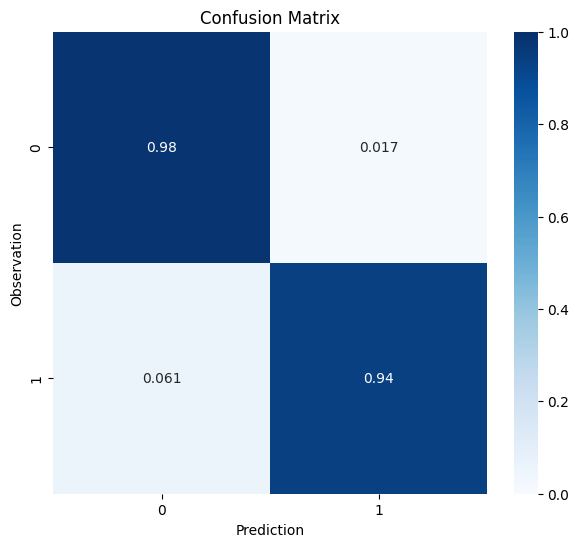

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))

normalized_cnf = cnf / cnf.sum(axis=1).reshape(-1, 1)

sns.heatmap(normalized_cnf, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=1)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

In [12]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


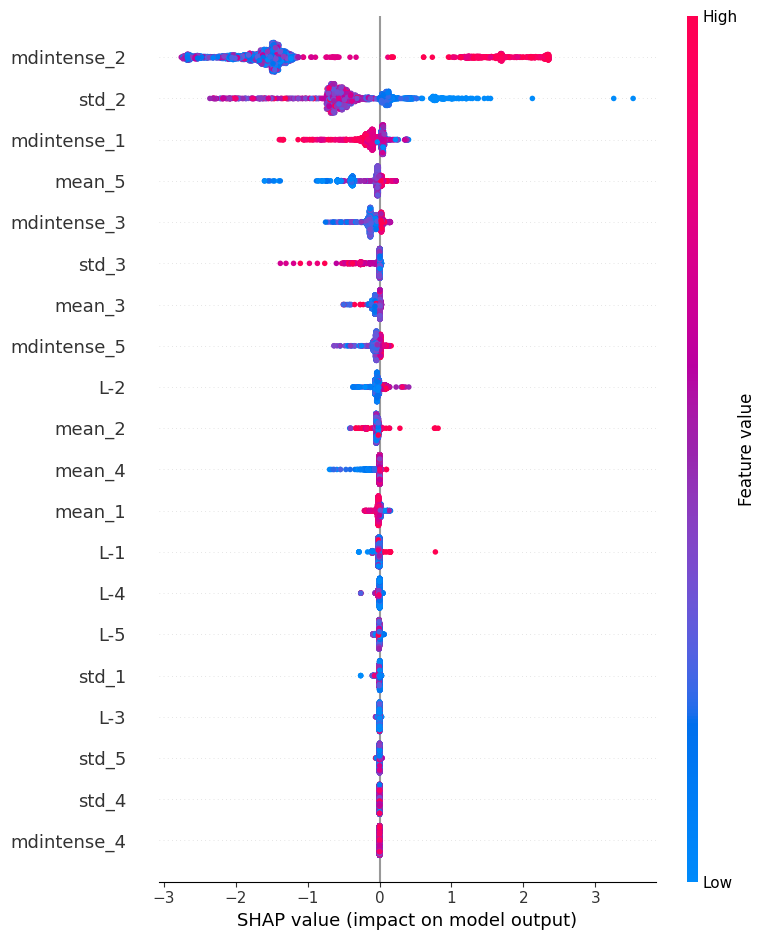

In [13]:
shap.summary_plot(shap_values, X)